In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for figures
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()
print(f"Lenth: {len(words)} | Data Sample: {words[:4]}")

Lenth: 32033 | Data Sample: ['emma', 'olivia', 'ava', 'isabella']


In [3]:
# Build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
BLOCK_SIZE = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * BLOCK_SIZE
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


#### Build the NN

In [5]:
# --------------------- Set Params --------------------- #
VOCAB = 27
char_space = 16
# 24 isn't much of an improvement and much longer training
W1x, W1y = BLOCK_SIZE * char_space, 220
# 250 and higher tend to overfit
# --------------------- Build the NN --------------------- #
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((VOCAB, char_space), generator=g) # nn space for char enc

W1 = torch.randn((W1x, W1y), generator=g)
b1 = torch.randn(W1y, generator=g)

W2 = torch.randn((W1y, VOCAB), generator=g)
b2 = torch.randn(27, generator=g)

params = [C, W1, b1, W2, b2]
print(f"Total Params: {sum(p.nelement() for p in params)}")

Total Params: 17179


In [6]:
for p in params:
    p.requires_grad = True # set gradients for tracking

#### Train the NN

In [7]:
# For learning rate exploration
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [8]:
lri = []
lossi = []
stepi = []

In [9]:
# ----------------------- Set Vars ----------------------- #
lr1, lr2, lr3 = 0.1, 0.05, 0.01
BATCH_SIZE = 64
EPOCHS = 300_000

# ----------------------- Train ----------------------- #
for i in range(EPOCHS):
    # Construct mini-batch
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))

    # forward
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, W1x) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # update
    lr = lr1 if i < 100_000 else lr2 if i < 200_00 else lr3
    for p in params:
        p.data += -lr * p.grad

# Stats
stepi.append(i)
lossi.append(loss.log10().item())


In [10]:
# plt.plot(stepi, lossi)

#### Evaluate the NN

In [11]:
def print_loss(X:torch.Tensor, Y:torch.Tensor):
    emb = C[X]
    h = torch.tanh(emb.view(-1, W1x) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(f"Loss: {loss}\n")

In [12]:
print("Train:")
print_loss(Xtr, Ytr)
print("Validation:")
print_loss(Xdev, Ydev)
# print("Test:")
# print_loss(Xte, Yte)

Train:
Loss: 2.0559957027435303

Validation:
Loss: 2.1357123851776123



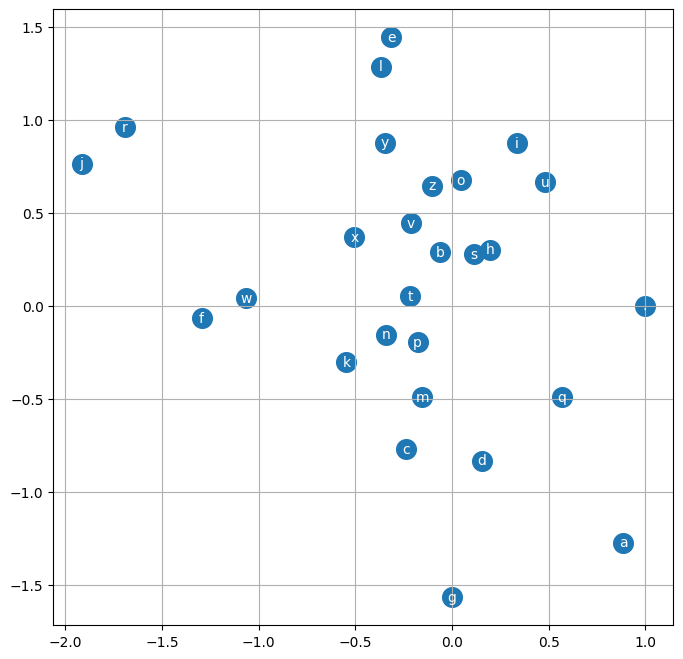

In [13]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

#### Sample the NN

In [14]:
def sample(g: torch.Generator):
    out = []
    context = [0] * BLOCK_SIZE # initialize with all...
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: break

    print(''.join(itos[i] for i in out))

In [15]:
g = torch.Generator().manual_seed(125)
for _ in range(10):
    sample(g)

japetra.
jus.
matim.
saph.
sahni.
kayleigit.
zon.
kayce.
shaan.
aviow.
